# Performance on simulated electrons and photons

In [8]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from helpers import *
from loaders import *
from initializers import initialisation_for_calorimetry_shower

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
today = '19_11_18'

In [10]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/pdfs/
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/shower_calo/'
save_folder_pdfs = save_folder + 'pdfs/'

## Loading and initializing

In [11]:
branches = [
    'run',
    'sub',
    'evt',
    
    'generation',
    'backtracked_pdg',
    'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
    'backtracked_start_x',
    'backtracked_start_y',
    'backtracked_start_z',
    'backtracked_start_t',
    'backtracked_sce_start_x',
    'backtracked_sce_start_y',
    'backtracked_sce_start_z',
    
    'nplanehits_U',
    'nplanehits_V',
    'nplanehits_Y',
    'trk_score',

    'trk_start_x',
    'trk_start_y',
    'trk_start_z',
    
    'trk_sce_start_x',
    'trk_sce_start_y',
    'trk_sce_start_z',

    'trk_end_x',
    'trk_end_y',
    'trk_end_z',
    
    'trk_sce_end_x',
    'trk_sce_end_y',
    'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',

    'trk_len',
    
#     'dqdx_u',
#     'dqdx_v',
#     'dqdx_y',

    'dedx_u',
    'dedx_v',
    'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
#     'x_u',
#     'x_v',
#     'x_y',
    
#     'y_u',
#     'y_v',
#     'y_y',
    
#     'z_u',
#     'z_v',
#     'z_y',
    
    'dir_x_u',
    'dir_x_v',
    'dir_x_y',
    
    'dir_y_u',
    'dir_y_v',
    'dir_y_y',
    
    'dir_z_u',
    'dir_z_v',
    'dir_z_y',
]

In [12]:
# Declaring files, folder and tree

directory = '~/Desktop/MicroBooNE/calorimetry_likelihood/v03/'

folder = "nuselection"
tree = "CalorimetryAnalyzer"

split_factor = 0.05
split_factor2 = 0.1

file_lists = {}
arrays_train = {}
arrays_test = {}

file_lists['nue'] = directory + 'bnb_nue_shr/out.root'
file_lists['ccpi0'] = directory + 'bnb_ccpi0_shr/out.root'
file_lists['ncpi0'] = directory + 'bnb_ncpi0_shr/out.root'

In [13]:
#Loading arrays
for name, file_path in file_lists.items():
    root_file = uproot.open(file_path)[folder][tree]
    entry_split = int(len(root_file) * split_factor)
    entry_split2 = int(len(root_file) * split_factor2)
    arrays_train[name] = root_file.arrays(branches, namedecode="utf-8", entrystop=entry_split)
    arrays_test[name] = root_file.arrays(branches, namedecode="utf-8", entrystart=entry_split, entrystop=entry_split2)

In [14]:
# Merging nue, nu, and ncpi0
array_train = {}
array_test = {}
for variable in branches:
    array_train[variable] = awkward.concatenate([array[variable] for array in arrays_train.values()])    
    array_test[variable] = awkward.concatenate([array[variable] for array in arrays_test.values()])

In [15]:
# initialising arrays
for array in [array_train, array_test]:
    initialisation_for_calorimetry_shower(array)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/helpers.py:89: RuntimeWarning: overflow encountered in square
  (point1_y - point2_y)**2 +
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/helpers.py:90: RuntimeWarning: overflow encountered in square
  (point1_z - point2_z)**2 )
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in subtract
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
def selection_mask(array):
    for plane in ['_u', '_v', '_y']:
        unit_v = np.sqrt(array['dir_z'+plane]**2 + array['dir_x'+plane]**2 + array['dir_y'+plane]**2)
        mask = (unit_v > 0.999).all() &\
              (unit_v < 1.001).all() &\
              (np.abs(array['dir_x'+plane]) != 1).all() &\
              (np.abs(array['dir_y'+plane]) != 1).all() &\
              (np.abs(array['dir_z'+plane]) != 1).all()
    return mask

def selection_efficiency(array):
    sel_mask = selection_mask(array)
    print("complete selection eff = {:.3f}".format(sel_mask.sum()/len(sel_mask)))

In [20]:
selection_efficiency(array_train)

complete selection eff = 0.963


In [53]:
def selection_for_train(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['distance_3d_start'] < 3) &\
           (array['distance_3d_start'] > 0) &\
           ((abs(array['backtracked_pdg']) == 11) | (abs(array['backtracked_pdg']) == 22))

In [54]:
#declaring some masks
selection_train = selection_for_train(array_train)
selection_test = selection_for_train(array_test)

electron_train = (abs(array_train['backtracked_pdg']) == 11)
photon_train = (abs(array_train['backtracked_pdg']) == 22)

electron_test = (abs(array_test['backtracked_pdg']) == 11)
photon_test = (abs(array_test['backtracked_pdg']) == 22)

In [55]:
# Easy start point resolution studies

Text(0.0, 1.0, 'Electron and photon candidates in BNB\nbacktracked to electrons and photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary')

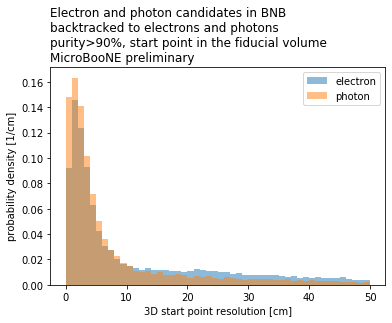

In [56]:
def base_selection_for_res_start_study(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           ((abs(array['backtracked_pdg']) == 11) | (abs(array['backtracked_pdg']) == 22))

base_sel = base_selection_for_res_start_study(array_train)
plt.hist(array_train['distance_3d_start'][electron_train & base_sel], bins=50, range=[0,50], alpha=0.5, density=True, label='electron')
plt.hist(array_train['distance_3d_start'][photon_train & base_sel], bins=50, range=[0,50], alpha=0.5, density=True, label='photon')
plt.legend()
plt.xlabel('3D start point resolution [cm]')
plt.ylabel('probability density [1/cm]')
plt.title('Electron and photon candidates in BNB\nbacktracked to electrons and photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary', loc='left')

Text(0.0, 1.0, 'Photon candidates in BNB\nbacktracked to photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary')

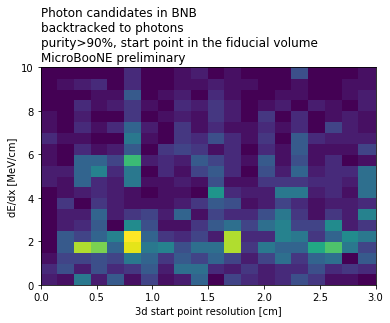

In [57]:
dedx_y = array_train['dedx_y'][photon_train & selection_train & (array_train['range_y']<4)]
dist_3d = (array_train['distance_3d_start']*(array_train['dedx_y'] == array_train['dedx_y']))[photon_train & selection_train & (array_train['range_y']<4)] 

plt.hist2d(dist_3d.flatten(), dedx_y.flatten(), range=[[0, 3], [0, 10]], bins=[20, 20])
plt.xlabel("3d start point resolution [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title('Photon candidates in BNB\nbacktracked to photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary', loc='left')

## Lookup Tables

In [58]:
## two parameters
# parameters_names = ['range', 'abs_pitch']
# parameters_bin_edges = [[0., 4, 20, np.inf],
#                   [.0, 1.5, 3, np.inf]]

# dedx_var = 'dedx'
# dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 30, 50, np.inf]

# parameters = []
# dedx_vars = []
# for plane in ['u', 'v', 'y']:
#     parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
#     dedx_vars.append(dedx_var+'_'+plane)

# pdgcode_var = 'backtracked_pdg'

In [59]:
# one parameter (pitch only)
parameters_names = ['pitch']
parameters_bin_edges = [[.0, 3, 10, np.inf]]

dedx_var = 'dedx'
# dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 20, np.inf]
dedx_bins = np.linspace(0, 20, 40)

parameters = []
dedx_vars = []
for plane in ['u', 'v', 'y']:
    parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
    dedx_vars.append(dedx_var+'_'+plane)

pdgcode_var = 'backtracked_pdg'

In [60]:
# declaring caloLikelihood objects
caloLike_train = caloLikelihood(array_train, quality_mask=selection_train)
caloLike_test = caloLikelihood(array_test, quality_mask=selection_test)

caloLike_train.setPdgCodeVar(pdgcode_var)
caloLike_test.setPdgCodeVar(pdgcode_var)

In [61]:
# building lookup tables and likelihood variables
array = caloLike_test.array
for i in [0, 1, 2]:
    caloLike_train.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_train.buildLookUpTableMC(i, 11)    
    caloLike_train.buildLookUpTableMC(i, 22)    
    caloLike_train.buildLookUpLogLikelihoodRatio(i, [11, 22])
    caloLike_test.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_test.lookup_tables = caloLike_train.lookup_tables    
    
#     array['like_11_{}'.format(i)] = caloLike_train.likelihoodWholeDataset(array=array, 
#                                       plane_num=i, 
#                                       pdg_code=11)
#     array['like_22_{}'.format(i)] = caloLike_train.likelihoodWholeDataset(array=array, 
#                                       plane_num=i, 
#                                       pdg_code=22)
#     array['like_11_sum_{}'.format(i)] = array['like_11_{}'.format(i)].sum()
#     array['like_22_sum_{}'.format(i)] = array['like_22_{}'.format(i)].sum()
#     array['log_like_ratio_{}'.format(i)] = array['like_11_sum_{}'.format(i)] - array['like_22_sum_{}'.format(i)]
    
# array['log_like_ratio'] = array['log_like_ratio_0'] + array['log_like_ratio_1'] + array['log_like_ratio_2']
# array['log_like_ratio_01'] = array['log_like_ratio_0'] + array['log_like_ratio_1']

In [62]:
# DUMP LOOKUP TABLE ON A C++ FILE
# caloLike_train.printCplusplusCode(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/outlookup.h', planes=[0, 1, 2])

## Plot of the pdfs/likelihoods in bins of residual range and pitch

### Plot PDFs from lookup tables

In [63]:
#Plot PDF 2parameters
# for plane_num in [0, 1, 2]:
#     bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
#     for bin_center in bin_centers:
#         caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
#                                   pdg_code=11, 
#                                   parameters_value=bin_center, 
#                                   label='electron')
#         caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
#                                   pdg_code=22, 
#                                   parameters_value=bin_center, 
#                                   label='photon')
#         plt.xlim(0, 10)
#         plt.savefig(save_folder_pdfs+'plane_{}_rr_{}_pitch_{}.png'.format(plane_num, bin_center[0], bin_center[1]), dpi=250)
#         plt.close()

In [64]:
#Plot PDF 1parameters
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=11, 
                                  parameters_value=bin_center, 
                                  label='electron')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=22, 
                                  parameters_value=bin_center, 
                                  label='photon')
        plt.xlim(0, 20)
        plt.savefig(save_folder_pdfs+'plane_{}_pitch_{}.png'.format(plane_num, bin_center[0]), dpi=250)
        plt.close()